In [1]:
!rm libdevice.10.bc
!ln -s /opt/conda/nvvm/libdevice/libdevice.10.bc ./libdevice.10.bc

# RANDOM SEED = 42
import numpy as np
import random
import tensorflow as tf
import os

def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
set_seeds(42)

2025-07-09 16:38:34.186173: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-09 16:38:34.376521: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752079114.402898    1282 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752079114.413743    1282 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-09 16:38:34.524467: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# LOAD DATASET

import boto3

bucket_name = 'mri-patches-nogroundtruths'
object_key = 'MRI_patches_combined.npz'
download_path = './MRI_patches_combined.npz'

s3 = boto3.client('s3')
s3.download_file(bucket_name, object_key, download_path)

print("Downloaded MRI_patches_combined.npz")

data = np.load('MRI_patches_combined.npz')
patches = data['patches']
labels = data['labels']

print("Label distribution:", np.bincount(labels))

# SPLIT INTO TRAINING & TESTING DATA

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Reshape patches to include channel dimension (grayscale = 1)
patches = patches[..., np.newaxis]  # (N, 32, 32) → (N, 32, 32, 1)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    patches, labels, test_size=0.15, random_state=42, stratify=labels
)

print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)

Downloaded MRI_patches_combined.npz
Label distribution: [132235   2165]
Training set: (114240, 32, 32, 1) (114240,)
Validation set: (20160, 32, 32, 1) (20160,)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fixed_laplacian     │ (None, 32, 32, 1) │          0 │ input_layer_2[0]… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 32, 32,    │        640 │ fixed_laplacian[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_16      │ (None, 32, 32,    │          0 │ conv2d_16[0][0]   │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 32, 32,    │     36,928 │ leaky_re_lu_16[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 32, 32,    │        128 │ fixed_laplacian[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 32, 32,    │          0 │ conv2d_17[0][0],  │
│                     │ 64)               │            │ conv2d_18[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_17      │ (None, 32, 32,    │          0 │ add_6[0][0]       │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 32, 32,    │          0 │ leaky_re_lu_17[0… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 16, 16,    │          0 │ dropout_14[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 16, 16,    │     73,856 │ max_pooling2d_10… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_18      │ (None, 16, 16,    │          0 │ conv2d_19[0][0]   │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 16, 16,    │    147,584 │ leaky_re_lu_18[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 16, 16,    │      8,320 │ max_pooling2d_10… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 16, 16,    │          0 │ conv2d_20[0][0],  │
│                     │ 128)              │            │ conv2d_21[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_19      │ (None, 16, 16,    │          0 │ add_7[0][0]       │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 16, 16,    │          0 │ leaky_re_lu_19[0

 Total params: 456,372 (1.74 MB)

 Trainable params: 456,116 (1.74 MB)

 Non-trainable params: 256 (1.00 KB)

Stage 1: Training with Binary Crossentropy (Epochs 1–5)
Epoch 1/5
1782/1785 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9006 - auc: 0.9329 - loss: 0.3416 - precision: 0.8719 - recall: 0.9389
Epoch 1: val_recall improved from -inf to 0.20923, saving model to MRI_CCNN_model_laplacian.h5


1785/1785 ━━━━━━━━━━━━━━━━━━━━ 42s 15ms/step - accuracy: 0.9007 - auc: 0.9329 - loss: 0.3414 - precision: 0.8720 - recall: 0.9389 - val_accuracy: 0.9817 - val_auc: 0.9438 - val_loss: 0.0644 - val_precision: 0.3778 - val_recall: 0.2092
Epoch 2/5
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9547 - auc: 0.9794 - loss: 0.1500 - precision: 0.9312 - recall: 0.9820
Epoch 2: val_recall improved from 0.20923 to 0.28615, saving model to MRI_CCNN_model_laplacian.h5


1785/1785 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.9547 - auc: 0.9794 - loss: 0.1500 - precision: 0.9312 - recall: 0.9820 - val_accuracy: 0.9814 - val_auc: 0.9420 - val_loss: 0.0646 - val_precision: 0.3941 - val_recall: 0.2862
Epoch 3/5
1784/1785 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9681 - auc: 0.9848 - loss: 0.1168 - precision: 0.9489 - recall: 0.9896
Epoch 3: val_recall did not improve from 0.28615
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.9682 - auc: 0.9848 - loss: 0.1168 - precision: 0.9489 - recall: 0.9896 - val_accuracy: 0.9831 - val_auc: 0.8866 - val_loss: 0.0727 - val_precision: 0.4487 - val_recall: 0.2154
Epoch 4/5
1782/1785 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9748 - auc: 0.9886 - loss: 0.0971 - precision: 0.9594 - recall: 0.9915
Epoch 4: val_recall did not improve from 0.28615
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.9748 - auc: 0.9886 - loss: 0.0971 - precision: 0.9594 - recall: 0.9915 - val_accuracy: 0.9825 -

1785/1785 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.9671 - auc: 0.9841 - loss: 0.1264 - precision: 0.9477 - recall: 0.9887 - val_accuracy: 0.9813 - val_auc: 0.9664 - val_loss: 0.0943 - val_precision: 0.4065 - val_recall: 0.3477
Epoch 2/15
1782/1785 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9750 - auc: 0.9879 - loss: 0.1101 - precision: 0.9600 - recall: 0.9913
Epoch 2: val_recall did not improve from 0.34769
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.9750 - auc: 0.9879 - loss: 0.1101 - precision: 0.9600 - recall: 0.9913 - val_accuracy: 0.9831 - val_auc: 0.9096 - val_loss: 0.1028 - val_precision: 0.3810 - val_recall: 0.0738
Epoch 3/15
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9791 - auc: 0.9900 - loss: 0.1038 - precision: 0.9661 - recall: 0.9929
Epoch 3: val_recall did not improve from 0.34769
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.9791 - auc: 0.9900 - loss: 0.1038 - precision: 0.9661 - recall: 0.9929 - val_accuracy: 0.9814

1785/1785 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.9832 - auc: 0.9933 - loss: 0.0960 - precision: 0.9730 - recall: 0.9940 - val_accuracy: 0.9792 - val_auc: 0.9420 - val_loss: 0.0992 - val_precision: 0.3716 - val_recall: 0.4185
Epoch 6/15
1782/1785 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9852 - auc: 0.9941 - loss: 0.0930 - precision: 0.9764 - recall: 0.9945
Epoch 6: val_recall did not improve from 0.41846
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.9852 - auc: 0.9941 - loss: 0.0930 - precision: 0.9764 - recall: 0.9946 - val_accuracy: 0.9810 - val_auc: 0.9559 - val_loss: 0.0992 - val_precision: 0.3806 - val_recall: 0.2892
Epoch 7/15
1784/1785 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9861 - auc: 0.9948 - loss: 0.0915 - precision: 0.9774 - recall: 0.9952
Epoch 7: val_recall did not improve from 0.41846
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.9861 - auc: 0.9948 - loss: 0.0915 - precision: 0.9774 - recall: 0.9952 - val_accuracy: 0.9829

1785/1785 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.9882 - auc: 0.9961 - loss: 0.0873 - precision: 0.9810 - recall: 0.9958 - val_accuracy: 0.9814 - val_auc: 0.9237 - val_loss: 0.0966 - val_precision: 0.4241 - val_recall: 0.4215
Epoch 10/15
1783/1785 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9886 - auc: 0.9964 - loss: 0.0861 - precision: 0.9821 - recall: 0.9954
Epoch 10: val_recall did not improve from 0.42154
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.9886 - auc: 0.9964 - loss: 0.0861 - precision: 0.9821 - recall: 0.9954 - val_accuracy: 0.9824 - val_auc: 0.8900 - val_loss: 0.0976 - val_precision: 0.4250 - val_recall: 0.2615
Epoch 11/15
1782/1785 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9899 - auc: 0.9967 - loss: 0.0843 - precision: 0.9839 - recall: 0.9961
Epoch 11: val_recall did not improve from 0.42154
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.9899 - auc: 0.9967 - loss: 0.0843 - precision: 0.9839 - recall: 0.9961 - val_accuracy: 0.

1785/1785 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.9904 - auc: 0.9969 - loss: 0.0832 - precision: 0.9848 - recall: 0.9963 - val_accuracy: 0.9788 - val_auc: 0.9322 - val_loss: 0.1004 - val_precision: 0.3816 - val_recall: 0.5108
Epoch 14/15
1782/1785 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9915 - auc: 0.9976 - loss: 0.0812 - precision: 0.9866 - recall: 0.9965
Epoch 14: val_recall did not improve from 0.51077
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.9915 - auc: 0.9976 - loss: 0.0811 - precision: 0.9866 - recall: 0.9965 - val_accuracy: 0.9830 - val_auc: 0.9254 - val_loss: 0.0989 - val_precision: 0.4520 - val_recall: 0.2462
Epoch 15/15
1784/1785 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9923 - auc: 0.9977 - loss: 0.0802 - precision: 0.9882 - recall: 0.9965
Epoch 15: val_recall did not improve from 0.51077
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.9923 - auc: 0.9977 - loss: 0.0802 - precision: 0.9882 - recall: 0.9965 - val_accuracy: 0.

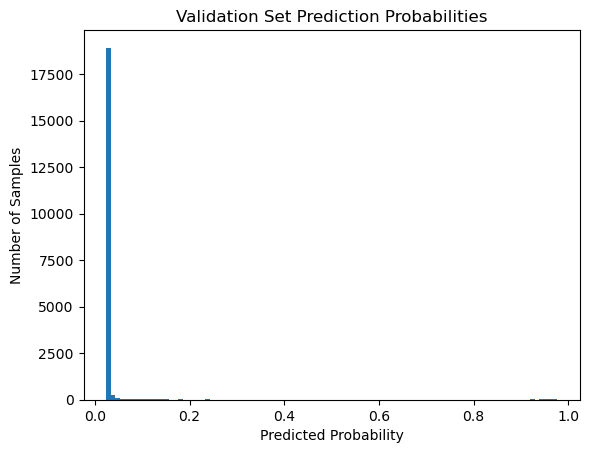

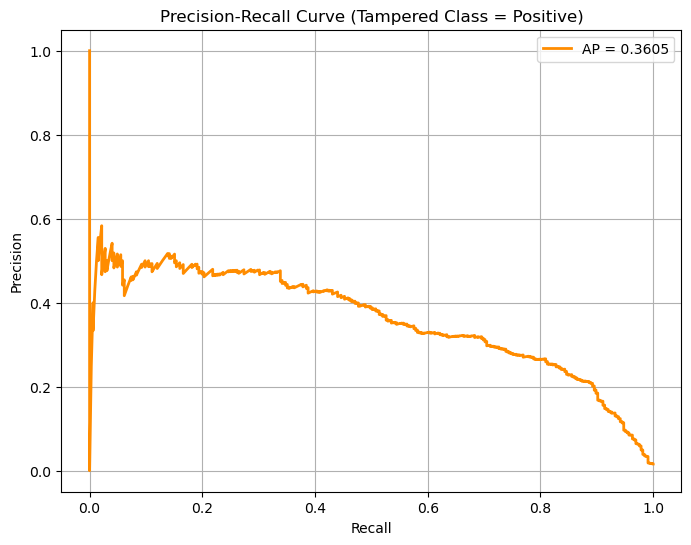

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Conv2D, Input, Dense, BatchNormalization, 
                                     MaxPooling2D, Dropout, Add, LeakyReLU, 
                                     GlobalAveragePooling2D, Reshape, multiply, 
                                     GlobalMaxPooling2D, Concatenate, Lambda, Activation)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras import backend as K

# SETTINGS
PATCH_SIZE = 32
BATCH_SIZE = 64
EPOCHS = 20
LEARNING_RATE = 1e-4
MODEL_PATH = 'MRI_CCNN_model_laplacian.h5'
VALIDATION_SPLIT = 0.15
L2_REG = 1e-5

# FIXED LAPLACIAN LAYER
def fixed_laplacian_layer(x):
    laplacian_kernel = np.array([[0, 1, 0],
                                  [1, -4, 1],
                                  [0, 1, 0]], dtype=np.float32).reshape((3, 3, 1, 1))
    kernel_tensor = tf.constant(laplacian_kernel)
    return tf.nn.conv2d(x, filters=kernel_tensor, strides=1, padding='SAME')

# LOSS FUNCTIONS
def focal_loss(gamma=2., alpha=0.5): 
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred)
        weight = alpha * y_true * K.pow(1 - y_pred, gamma) + \
                 (1 - alpha) * (1 - y_true) * K.pow(y_pred, gamma)
        return K.mean(weight * cross_entropy, axis=-1)
    return focal_loss_fixed

def hybrid_loss_with_smoothed_bce(gamma=2.0, alpha=0.55, bce_weight=0.5, smoothing=0.05):
    fl = focal_loss(gamma=gamma, alpha=alpha)
    bce = tf.keras.losses.BinaryCrossentropy(label_smoothing=smoothing)
    def loss_fn(y_true, y_pred):
        return bce_weight * bce(y_true, y_pred) + (1 - bce_weight) * fl(y_true, y_pred)
    return loss_fn

# CBAM BLOCK
def cbam_block(x, ratio=8):
    channel = x.shape[-1]
    avg_pool = GlobalAveragePooling2D()(x)
    max_pool = GlobalMaxPooling2D()(x)

    shared_dense = Dense(channel // ratio, activation='relu', kernel_regularizer=l2(L2_REG))
    shared_out = Dense(channel, kernel_regularizer=l2(L2_REG))

    avg_out = shared_out(shared_dense(avg_pool))
    max_out = shared_out(shared_dense(max_pool))
    channel_attention = Add()([avg_out, max_out])
    channel_attention = Activation('sigmoid')(channel_attention)
    channel_attention = Reshape((1, 1, channel))(channel_attention)
    x = multiply([x, channel_attention])

    avg_pool_spatial = Lambda(lambda t: K.mean(t, axis=3, keepdims=True))(x)
    max_pool_spatial = Lambda(lambda t: K.max(t, axis=3, keepdims=True))(x)
    concat = Concatenate(axis=-1)([avg_pool_spatial, max_pool_spatial])
    spatial_attention = Conv2D(1, (7, 7), padding='same', activation='sigmoid',
                               kernel_regularizer=l2(L2_REG))(concat)
    x = multiply([x, spatial_attention])
    return x

# BUILD CCNN
def build_ccnn(input_shape=(32, 32, 1)):
    inputs = Input(shape=input_shape)
    
    # Fixed Laplacian layer
    x = Lambda(fixed_laplacian_layer, name='fixed_laplacian')(inputs)

    # Residual block 1
    res = x
    x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(L2_REG))(res)
    x = LeakyReLU(negative_slope=0.1)(x)
    x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(L2_REG))(x)
    res = Conv2D(64, (1, 1), padding='same', kernel_regularizer=l2(L2_REG))(res)
    x = Add()([x, res])
    x = LeakyReLU(negative_slope=0.1)(x)
    x = Dropout(0.2)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Residual block 2
    res2 = x
    x = Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(L2_REG))(res2)
    x = LeakyReLU(negative_slope=0.1)(x)
    x = Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(L2_REG))(x)
    res2 = Conv2D(128, (1, 1), padding='same', kernel_regularizer=l2(L2_REG))(res2)
    x = Add()([x, res2])
    x = LeakyReLU(negative_slope=0.1)(x)
    x = Dropout(0.2)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = cbam_block(x)

    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(L2_REG))(x)
    x = LeakyReLU(negative_slope=0.1)(x)
    x = Dropout(0.2)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = SeparableConv2D(128, (3, 3), padding='same',
                        depthwise_regularizer=l2(L2_REG),
                        pointwise_regularizer=l2(L2_REG))(x)
    x = LeakyReLU(negative_slope=0.1)(x)
    x = Dropout(0.2)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = SeparableConv2D(128, (3, 3), padding='same',
                        depthwise_regularizer=l2(L2_REG),
                        pointwise_regularizer=l2(L2_REG))(x)
    x = LeakyReLU(negative_slope=0.1)(x)
    x = Dropout(0.2)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = SeparableConv2D(128, (3, 3), padding='same',
                        depthwise_regularizer=l2(L2_REG),
                        pointwise_regularizer=l2(L2_REG))(x)
    x = LeakyReLU(negative_slope=0.1)(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(L2_REG))(x)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(L2_REG))(x)
    x = Dropout(0.4)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=Adam(LEARNING_RATE),
        loss=hybrid_loss_with_smoothed_bce(gamma=2.0, alpha=0.55, bce_weight=0.5, smoothing=0.05),
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
    )
    return model
    
# CLASS BALANCE IN TRAINING

def balanced_batch_generator(tampered_X, tampered_y, untampered_X, untampered_y, batch_size):
    n = batch_size // 2

    tampered_indices = np.arange(len(tampered_X))
    untampered_indices = np.arange(len(untampered_X))

    while True:
        tampered_sample_idx = np.random.choice(tampered_indices, size=n, replace=True)
        untampered_sample_idx = np.random.choice(untampered_indices, size=n, replace=False)

        batch_X = np.concatenate([tampered_X[tampered_sample_idx], untampered_X[untampered_sample_idx]], axis=0)
        batch_y = np.concatenate([tampered_y[tampered_sample_idx], untampered_y[untampered_sample_idx]], axis=0)

        perm = np.random.permutation(len(batch_y))
        yield batch_X[perm], batch_y[perm]

# SPLIT TRAINING DATA BY LABEL

tampered_mask = (y_train == 1)
untampered_mask = (y_train == 0)

tampered_X_train = X_train[tampered_mask]
tampered_y_train = y_train[tampered_mask]
untampered_X_train = X_train[untampered_mask]
untampered_y_train = y_train[untampered_mask]

# COMPILE CCNN

model = build_ccnn()
model.summary()

# UPDATE CCNN & EARLY STOPPING

checkpoint = ModelCheckpoint(
    MODEL_PATH,
    monitor='val_recall',
    mode='max',
    save_best_only=True,
    verbose=1
)

earlystop = EarlyStopping(
    monitor='val_recall',
    mode='max',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# GENERATE TRAINING BATCHES

train_generator = balanced_batch_generator(
    tampered_X_train, tampered_y_train,
    untampered_X_train, untampered_y_train,
    batch_size=BATCH_SIZE
)

steps_per_epoch = len(y_train) // BATCH_SIZE

# TRAIN CCNN

# Define BCE and hybrid loss separately
bce_loss = tf.keras.losses.BinaryCrossentropy()
hybrid = hybrid_loss_with_smoothed_bce(gamma=2.0, alpha=0.55, bce_weight=0.5, smoothing=0.05)

# Stage 1 (Epochs 1-5): Train with BCE
print("Stage 1: Training with Binary Crossentropy (Epochs 1–5)")
model.compile(
    optimizer=Adam(LEARNING_RATE),
    loss=bce_loss,
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc')
    ]
)

history_bce = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=5,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint, earlystop],
    shuffle=False
)

# Stage 2 (Epochs 6-Stop): Train with Hybrid Loss
print("Stage 2: Training with Hybrid Loss (Epochs 6–20)")
model.compile(
    optimizer=Adam(LEARNING_RATE),
    loss=hybrid,
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc')
    ]
)

history_hybrid = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS - 5,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint, earlystop],
    shuffle=False
)

# THRESHOLD EVALUATION

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, average_precision_score

y_val_probs = model.predict(X_val)

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
for thresh in thresholds:
    y_val_pred = (y_val_probs > thresh).astype(int)
    print(f"--- Threshold: {thresh} ---")
    print(classification_report(y_val, y_val_pred, digits=4))
    print(f"AUROC (using probs): {roc_auc_score(y_val, y_val_probs):.4f}\n")

# PROBABILITY VS. NUMBER OF SAMPLES GRAPH

plt.hist(y_val_probs, bins=100)
plt.title("Validation Set Prediction Probabilities")
plt.xlabel("Predicted Probability")
plt.ylabel("Number of Samples")
plt.show()

# Get predicted probabilities
y_scores = y_val_probs.ravel() 

# PRECISION VS. RECALL GRAPH

# Compute PR curve & area under PR curve
precision, recall, thresholds = precision_recall_curve(y_val, y_scores)
avg_precision = average_precision_score(y_val, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"AP = {avg_precision:.4f}", color="darkorange", linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Tampered Class = Positive)")
plt.grid(True)
plt.legend(loc="upper right")
plt.show()